In [1]:
import ROOT

Welcome to JupyROOT 6.12/06


In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [25]:
root_dir = '/home/artem145/NEWS/root_files/Valerio/'

In [122]:
def get_pol_feat(id_frame, n_pol, root_dir, class_name, feat_names):
    
    f = ROOT.TFile.Open(root_dir+class_name+'/dm_tracks.dm.root','read')
    t = f.Get('Vdmr')
    all_feat = pd.DataFrame(columns=feat_names).values
    
    for pol_id in id_frame[['ViewID','pol'+str(n_pol)]].values:
        pol_feat = []
        t.GetEntry(int(pol_id[0]))
        for name in feat_names:
            pol_feat.append(t.GetLeaf('cl.'+name).GetValue(int(pol_id[1])))
        all_feat = np.vstack((all_feat, pol_feat))
    return pd.DataFrame(all_feat, columns=feat_names)

In [124]:
def stack_pols(pol_frames, feat_names):
    
    stacked = pol_frames[0].drop(feat_names, axis=1).values
    feat_array = []
    for i in range(len(pol_frames)):
        stacked = np.hstack((stacked,pol_frames[i]))
        for name in feat_names:
            feat_array.append(name+str(i))
    return pd.DataFrame(stacked, columns=feat_array)

In [151]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one feature array
    and labeling 'signal' with 1 and 'noise' with 0.
    -------
    Output:
    X - array of features
    y - array of corresponding target labels
    """
    X = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
    y = []
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = np.ones(len(idx))
        else: targ = np.zeros(len(idx))
        y = np.append(y,targ)
        X = np.vstack((X, ft_data[name].values))
    return X, y

In [116]:
feat_names = ['x','y','z','lx','ly','phi','npx','vol']

In [132]:
class_names = ['C100keV', 'TestSample']

In [134]:
n_pols = 7

In [133]:
pol_ids = {}
for name in class_names:
    pol_ids[name] = pd.read_csv(root_dir+name+'/yandex_bfcl_'+name+'.txt').drop(['emp'],axis=1)

In [135]:
%%time
feat_data = {}
for name in class_names:
    pols = []
    for i in range(n_pols):
        pols.append(get_pol_feat(pol_ids[name], i, root_dir, name, feat_names))
    feat_data[name] = stack_pols(pols, feat_names)

CPU times: user 24min 46s, sys: 11.2 s, total: 24min 57s
Wall time: 24min 57s


In [149]:
copa = feat_data['C100keV']
for i in range(n_pols):
    copa = copa[ copa['lx'+str(i)]<1000 ]
feat_data['C100keV'] = copa

In [150]:
topa = feat_data['TestSample']
for i in range(n_pols):
    topa = topa[ topa['lx'+str(i)]<1000 ]
feat_data['TestSample'] = topa

In [152]:
X, y = feat_to_input(feat_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [154]:
X_train.shape

(32574, 56)

### Training

In [155]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.91918961985


In [157]:
feat_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['x3', 'x2', 'x4', 'x0', 'x6', 'x5', 'x1', 'y2', 'y1', 'y0', 'y6', 'y5',
       'y4', 'y3', 'phi0', 'phi3', 'ly6', 'phi1', 'phi5', 'ly2', 'phi6',
       'phi4', 'phi2', 'lx2', 'ly1', 'ly0', 'ly5', 'ly4', 'lx3', 'ly3', 'lx4',
       'npx6', 'lx6', 'lx5', 'lx1', 'npx2', 'npx0', 'npx4', 'lx0', 'npx5',
       'vol0', 'npx1', 'npx3', 'vol2', 'vol1', 'vol6', 'vol4', 'vol3', 'vol5',
       'z0', 'z6', 'z3', 'z1', 'z2', 'z5', 'z4'],
      dtype='object')

* Dropping unphysical 'z'

In [158]:
feat_noz_data = {}
for name in class_names:
    copa = feat_data[name]
    for i in range(n_pols):
        copa = copa.drop(['z'+str(i)],axis=1)
    feat_noz_data[name] = copa

In [160]:
X, y = feat_to_input(feat_noz_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [161]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.858779466843


In [162]:
feat_noz_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['x0', 'x2', 'x1', 'x5', 'x4', 'y5', 'x6', 'x3', 'y2', 'y0', 'y3', 'y6',
       'y4', 'y1', 'phi3', 'phi2', 'phi1', 'phi5', 'phi0', 'phi4', 'lx2',
       'phi6', 'lx1', 'lx3', 'ly4', 'lx4', 'ly5', 'lx6', 'ly0', 'lx5', 'ly1',
       'lx0', 'ly6', 'ly3', 'npx5', 'npx6', 'ly2', 'npx0', 'npx4', 'npx1',
       'npx2', 'vol2', 'vol6', 'npx3', 'vol1', 'vol0', 'vol5', 'vol3', 'vol4'],
      dtype='object')

### Performance without directionallity

In [169]:
feat_noz_nophi_data = {}
for name in class_names:
    copa = feat_noz_data[name]
    for i in range(n_pols):
        copa = copa.drop(['phi'+str(i)],axis=1)
    feat_noz_nophi_data[name] = copa

In [170]:
X, y = feat_to_input(feat_noz_nophi_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [180]:
%%time
randcla = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.85201793722
CPU times: user 6min 46s, sys: 1.97 s, total: 6min 48s
Wall time: 22.5 s


In [181]:
feat_noz_nophi_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['x2', 'x6', 'x3', 'y5', 'y6', 'x5', 'x0', 'y1', 'x4', 'x1', 'y0', 'y2',
       'y4', 'y3', 'lx2', 'lx3', 'lx1', 'npx5', 'lx4', 'ly0', 'ly5', 'ly3',
       'ly6', 'lx6', 'ly4', 'npx6', 'ly1', 'lx0', 'lx5', 'ly2', 'npx4', 'npx0',
       'npx1', 'npx2', 'npx3', 'vol1', 'vol0', 'vol6', 'vol2', 'vol5', 'vol3',
       'vol4'],
      dtype='object')

In [182]:
roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1])

0.86076945982885333

In [183]:
%%time
boocla = GradientBoostingClassifier(n_estimators=1000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.86255742852
CPU times: user 2min 5s, sys: 61.6 ms, total: 2min 5s
Wall time: 2min 4s


* 10000

In [184]:
%%time
randcla = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
randcla.fit(X_train, y_train)
print(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))

0.862003338219
CPU times: user 1h 7min 25s, sys: 18.3 s, total: 1h 7min 44s
Wall time: 3min 36s


In [185]:
%%time
boocla = GradientBoostingClassifier(n_estimators=10000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.856034591592
CPU times: user 23min 1s, sys: 2.59 s, total: 23min 3s
Wall time: 22min 57s


## Performance vs n_trees

In [186]:
n_est = [50, 100, 500, 1000, 5000, 10000]

In [187]:
%%time
boo_rocs = []
for n in n_est:
    boocla.set_params(n_estimators=n)
    boocla.fit(X_train, y_train)
    boo_rocs.append(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))
    print(n,'  \t', boo_rocs[-1])

50   	 0.835440097777
100   	 0.842593962298
500   	 0.857689246527
1000   	 0.86271766118
5000   	 0.860653939537
10000   	 0.856294312129
CPU times: user 36min 16s, sys: 2.36 s, total: 36min 19s
Wall time: 36min 13s


In [188]:
%%time
rand_rocs = []
for n in n_est:
    randcla.set_params(n_estimators=n)
    randcla.fit(X_train, y_train)
    rand_rocs.append(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))
    print(n,'  \t', rand_rocs[-1])

50   	 0.853438301049
100   	 0.858207955737
500   	 0.861341000532
1000   	 0.861341983976
5000   	 0.86193269039
10000   	 0.861847176557
CPU times: user 1h 52min 12s, sys: 28.8 s, total: 1h 52min 40s
Wall time: 6min 2s


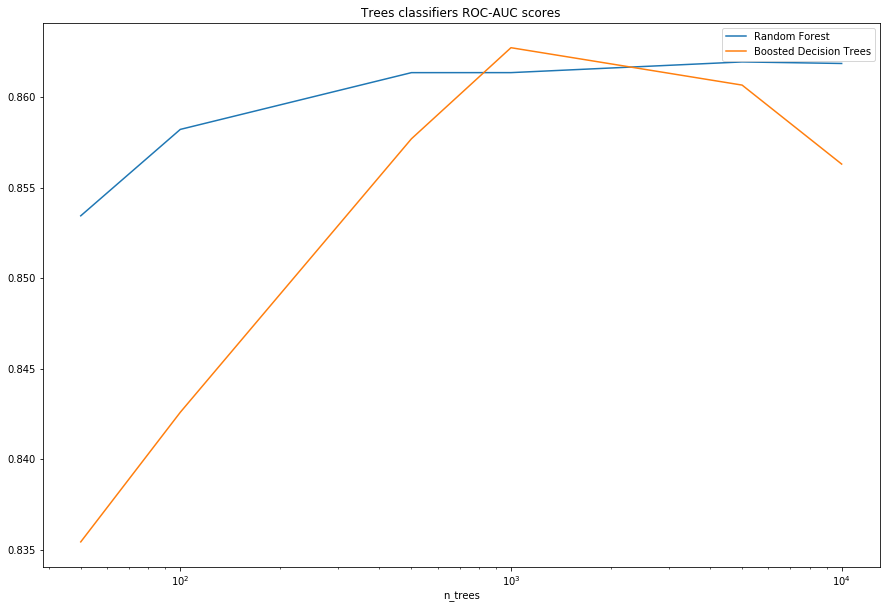

In [189]:
#plot
plt.figure(figsize=(15,10))
plt.plot(n_est, rand_rocs, label='Random Forest')
plt.plot(n_est, boo_rocs, label='Boosted Decision Trees')
plt.title('Trees classifiers ROC-AUC scores')
plt.xlabel('n_trees')
plt.xscale('log')
plt.legend()
plt.savefig('trees.pdf')

# 51. TESTING AREA

In [3]:
f = ROOT.TFile.Open('/home/artem145/NEWS/root_files/Valerio/TestSample/dm_tracks.dm.root','read')

Warning in <TClass::Init>: no dictionary for class DMRViewHeader is available
Warning in <TClass::Init>: no dictionary for class DMRAffine2D is available
Warning in <TClass::Init>: no dictionary for class DMRCluster is available
Warning in <TClass::Init>: no dictionary for class DMRGrain is available
Warning in <TClass::Init>: no dictionary for class DMRMicrotrack is available
Warning in <TClass::Init>: no dictionary for class DMRImageCl is available
Warning in <TClass::Init>: no dictionary for class DMRImage is available
Warning in <TClass::Init>: no dictionary for class DMRFrame is available


In [4]:
t = f.Get('Vdmr')

In [79]:
t.GetEntry(0)

480528

In [80]:
t.GetLeaf('cl.ly').GetValue(1027)

0.1619206815958023

In [107]:
copa = pd.read_csv(root_dir+'TestSample/yandex_bfcl_TestSample.txt').drop(['emp'],axis=1)
copa.head(10)

,ViewID,GrainID,pol0,pol1,pol2,pol3,pol4,pol5,pol6
0,0,0,2128,2137,2147,2156,2163,2171,2177
1,0,4,2333,2337,2340,2343,2348,2349,2352
2,0,6,2533,2537,2538,2541,2544,2546,2548
3,0,19,1718,1719,1720,1721,1722,1713,1723
4,0,24,1658,1659,1661,1662,1663,1664,1665
5,0,28,1588,1589,1591,1594,1596,1598,1600
6,0,38,1481,1484,1486,1458,1460,1462,1465
7,0,39,2457,2459,2461,2446,2448,2450,2451
8,0,41,1538,1540,1542,1543,1544,1545,1547
9,0,57,1317,1321,1322,1324,1326,1328,1331


In [123]:
get_pol_feat(copa, 0, root_dir, 'TestSample', feat_names)

,x,y,z,lx,ly,phi,npx,vol
0,20.7725,-15.9359,-22.95,0.181091,0.14048,0.267327,39,316
1,20.2258,22.9718,-23.95,0.737818,0.32068,0.608326,172,10548
2,20.0909,22.9088,-23.15,0.427617,0.215545,1.59147,60,1571
3,27.2961,22.7063,-15.2,0.163098,0.146182,0.81736,28,147
4,31.0651,16.1804,-12.95,0.288794,0.192397,2.89978,62,624
5,-17.1805,-12.5477,-9.89999,0.156909,0.126439,3.10148,24,98
6,-3.58511,4.37885,-6.14999,0.172602,0.163477,1.8544,42,296
7,-3.58511,4.37885,-6.14999,0.172602,0.163477,1.8544,42,296
8,27.3653,8.26267,-7.95,0.182456,0.119498,1.71132,21,95
9,-14.3187,3.22776,-1.75,0.249806,0.159788,2.55189,27,107


In [128]:
%%time
pols = []
for i in range(7):
    pols.append(get_pol_feat(copa, i, root_dir, 'TestSample', feat_names))
feat_data = stack_pols(pols, feat_names)

CPU times: user 1min 45s, sys: 3.38 s, total: 1min 49s
Wall time: 1min 49s


In [130]:
feat_data.head(5)

,x0,y0,z0,lx0,ly0,phi0,npx0,vol0,x1,y1,...,npx5,vol5,x6,y6,z6,lx6,ly6,phi6,npx6,vol6
0,20.7725,-15.9359,-22.95,0.181091,0.14048,0.267327,39,316,20.7633,-15.9407,...,45,355,20.7716,-15.9525,-22.95,0.187638,0.144514,0.395403,46,418
1,20.2258,22.9718,-23.95,0.737818,0.32068,0.608326,172,10548,20.2259,22.9667,...,37,415,20.5057,23.1455,-23.95,0.544898,0.303975,2.50439,27,268
2,20.0909,22.9088,-23.15,0.427617,0.215545,1.59147,60,1571,20.097,22.8952,...,9,236,20.2524,23.0559,-23.2,0.0688121,0.0688121,0,5,102
3,27.2961,22.7063,-15.2,0.163098,0.146182,0.81736,28,147,27.2934,22.712,...,6,16,27.296,22.6969,-15.25,0.209391,0.152747,3.04847,23,87
4,31.0651,16.1804,-12.95,0.288794,0.192397,2.89978,62,624,31.0564,16.1784,...,55,430,31.0325,16.1644,-13,0.257539,0.183618,3.04189,66,572


In [131]:
feat_data.max()

x0          31.514744
y0          23.358540
z0          25.000000
lx0          8.994473
ly0          0.985966
phi0         3.141593
npx0       795.000000
vol0    111656.000000
x1          31.522024
y1          23.357155
z1          25.050003
lx1          8.718125
ly1          0.964369
phi1         3.141593
npx1       784.000000
vol1    106240.000000
x2          31.518240
y2          23.352034
z2          25.050003
lx2         13.345671
ly2          0.928348
phi2         3.141593
npx2       747.000000
vol2     98825.000000
x3          31.520700
y3          23.345196
z3          25.050003
lx3      45348.410156
ly3          0.980012
phi3         3.141593
npx3       747.000000
vol3     92357.000000
x4          31.515577
y4          23.344046
z4          25.050003
lx4     252528.765625
ly4          0.994058
phi4         3.141593
npx4       698.000000
vol4     82241.000000
x5          31.509003
y5          23.344833
z5          25.050003
lx5      35785.710938
ly5          0.960314
phi5      

In [87]:
t.GetLeaf('cl.ly').GetValue(2533)

0.2155449092388153

In [88]:
type(t.GetLeaf('cl.ly').GetValue(2533))

float

In [84]:
coco = copa['pol0'][0]

In [106]:
t.GetLeaf('cl.ly').GetValue(int(coco))

0.14048033952713013

In [94]:
ROOT.gROOT.ProcessLine('Int_t como = 5;')

5

In [105]:
ROOT.como = int(coco)

In [18]:
ROOT.gROOT.ProcessLine("2*sin(2.1*4.0)")

1

(double) 1.7091978


In [6]:
ROOT.gROOT.ProcessLine("struct staff_t { Float_t cl_x; TBranch b_cl_x; }" )

0

In [9]:
toto = ROOT.staff_t()
t.SetBranchAddress('cl.x', ROOT.AddressOf(toto,'cl_x'))

4

In [ ]:
t.MakeClass('readka')

In [14]:
toto.cl_x

0.0

In [17]:
i=0
while t.GetEntry(i):
    copa =  t.GetEntry(i)
    print(copa)
    i+=1

480528
446272
425656
381892
454396
414332
394440
392332
421580
440820
384772
426596
532988
430132
396288
381284
415212
396004
401164
387752
462028
454548
426748
408548
424492
387724
316784
8996044
29339308
383096
372368
365428
327820
353056
354472
347820
376204
365256
400872
314288
343680
310148
357380
303164
317640
464932
366212
308324
296520
669908
40218636
8433784
323688
332052
338776
376732
342908
402440
367500
314684
313408
353112
336212
366720
320388
348660
579688
371584
391432
378016
403908
379168
336488
411896
367156
367696
355332
403096
389956
379996
384556
376332
364400
359020
329180
394980
340464
364816
324156
329864
348604
372820
348372
283652
301148
306648
307300
299712
287788
300376
306284
291396
386640
307876
330548
284480
5285360
16786212
278524
317460
330044
299328
352768
330260
291968
279796
318196
315872
291288
303984
290916
337496
301644
298992
283812
281388
302580
285800
292036
329856
351280
1624068
71168620
2460168
8585412
308036
323736
364940
292720
330608
316176